In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

| 01 | √ | Use SQLAlchemy `create_engine` to connect to your sqlite database.\
| 02 | √ | Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Exploration

In [8]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [9]:
# How many rows?
Measurements = session.query(Measurement).count()
Stations = session.query(Station).count()
print(f'Measures - {Measurements} rows')
print(f'Stations - {Stations} rows')

Measures - 19550 rows
Stations - 9 rows


In [10]:
# Using the inspector to print the column names within the 'Measurement' table and its types
print("Measurement: ")
print("=================")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

Measurement: 
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using the inspector to print the column names within the 'Station' table and its types
print("Station: ")
print("=================")
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

Station: 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Exploring
df_Measurement = pd.read_sql("SELECT * FROM measurement",
                     con=engine,
                     parse_dates=['date'])
df_Measurement["date"].describe()

count                   19550
unique                   2792
top       2010-10-25 00:00:00
freq                        9
first     2010-01-01 00:00:00
last      2017-08-23 00:00:00
Name: date, dtype: object

In [13]:
df_Measurement["prcp"].describe()

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

In [14]:
# What is the most recent date in the dataset?
# Alternative: session.query(Measurement.date).order_by(Measurement.date).first()
max_dt = session.query(func.max(Measurement.date)).scalar()
print(f'Before: {type(max_dt)}')

# Get the data into datetime format so we can use in an operator
from dateutil import parser
from dateutil.relativedelta import relativedelta

new_max_dt = parser.parse(max_dt)  # datetime.datetime(1999, 8, 28, 0, 0)
print(f'After: {type(new_max_dt)}')

Before: <class 'str'>
After: <class 'datetime.datetime'>


In [15]:
# Once you know the most recent data in the csv, what is the date exactly 12 months prior?
import dateutil as du
twelve_months = new_max_dt + relativedelta(months=-12)

print(f'Max datetime value in date column: {new_max_dt}')
print(f'Max datetime value to filter for (WHERE date >=): {twelve_months}')

Max datetime value in date column: 2017-08-23 00:00:00
Max datetime value to filter for (WHERE date >=): 2016-08-23 00:00:00


### Requirements:
| 03 | | **Precipitation Data**: Design a query to retrieve the last 12 months of precipitation data.\
| 04 | | Precipitation Data: Select only the `date` and `prcp` values.

In [16]:
# Slice out the columns you need: prcp and date
sel=[Measurement.prcp, Measurement.date]

# Query the dataset and put into variable
precip = session.query(*sel).filter(Measurement.date >= twelve_months).all()

| 05 | √ | Precipitation Data: Load the query results into a Pandas DataFrame and set the index to the date column.\
| 06 | √ | Precipitation Data: Sort the DataFrame values by `date`.

In [21]:
# Load dataframe and set index to the date column
dfPrecip = pd.DataFrame(precip, columns=['prcp', 'date'])

# Cleanup:
dfPrecip = dfPrecip.dropna(how='any') 

# Sort
dfPrecip = dfPrecip.sort_values(["date"], ascending=True)

# Set the index:
dfPrecip = dfPrecip.set_index("date")
dfPrecip.head(2)

,prcp
date,
2016-08-24,0.08
2016-08-24,1.22


In [29]:
dfPrecip.tail(2)

,prcp
date,
2017-08-23,0.00
2017-08-23,0.45


| 07 | √ | Precipitation Data: Plot the results using the DataFrame `plot` method.

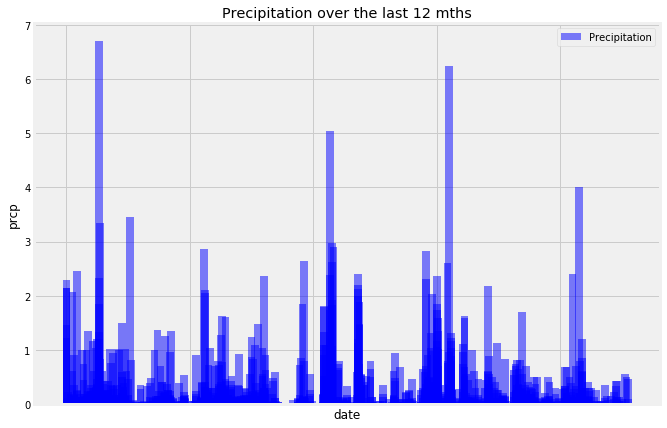

In [28]:
xx = dfPrecip.index.tolist()
yy = dfPrecip['prcp'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center", label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation over the last 12 mths")
plt.xlabel("date")
plt.ylabel("")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()


In [ ]:
sel = [Dow.stock, 
       func.avg(Dow.open_price), 
       func.avg(Dow.high_price), 
       func.avg(Dow.low_price), 
       func.avg(Dow.close_price)]
may_averages = session.query(*sel).\
    filter(func.strftime("%m", Dow.date) == "05").\
    group_by(Dow.stock).\
    order_by(Dow.stock).all()
may_averages

# Plot the Results in a Matplotlib bar chart
df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
df.set_index('stock', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.show()


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
